# Multi-Shell Free Water Elimination using MT-CSD (Applied to MAP-MRI)

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

/home/rutger/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


In [2]:
scheme_hcp.print_acquisition_info

Acquisition scheme summary

total number of measurements: 288
number of b0 measurements: 18
number of DWI shells: 3

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |18        |0               |0                        |10.6       |43.1      |N/A  
1           |90        |1000            |56                       |10.6       |43.1      |N/A  
2           |90        |2000            |79                       |10.6       |43.1      |N/A  
3           |90        |3000            |97                       |10.6       |43.1      |N/A  


In [3]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
wm, gm, csf, selection_map = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier07',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)
tissue_response = [wm, gm, csf]

## Synthetic study on effect of free water elimination on MAP-MRI Indices

### Effect of noise on response functions

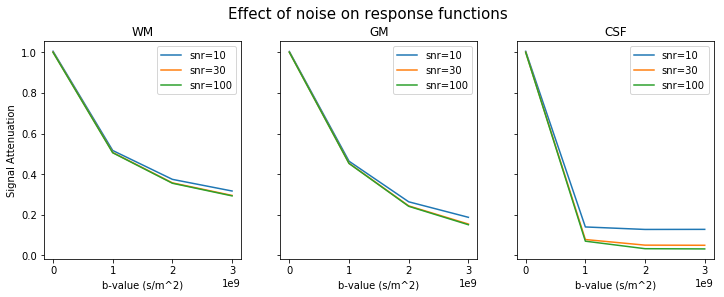

In [4]:
from dipy.sims.phantom import add_noise
import numpy as np
from dmipy.signal_models.tissue_response_models import (
    AnisotropicTissueResponseModel,
    IsotropicTissueResponseModel)
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(ncols=3, sharey=True, figsize=[12, 4])
for ax_, model, title in zip(ax, [wm, gm, csf], ['WM', 'GM', 'CSF']):
    data_synth = np.tile(model(scheme_hcp, mu=[0., 0.]), (1000, 1))
    for snr in [10, 30, 100]:
        data_noise = add_noise(data_synth, snr=snr)
        if model == wm:
            model_noise = AnisotropicTissueResponseModel(scheme_hcp, data_noise)
        else:
            model_noise = IsotropicTissueResponseModel(scheme_hcp, data_noise)
        ax_.plot(scheme_hcp.shell_bvalues, model_noise.tissue_response(), label='snr={}'.format(snr))
        ax_.set_title(title)
        ax_.set_xlabel('b-value (s/m^2)')
        ax_.legend()
ax[0].set_ylabel('Signal Attenuation')
fig.suptitle('Effect of noise on response functions', fontsize=15, y=1.);

Notice that the Rician noise especially affects the CSF response function as the positive bias becomes apparent at low signal values. It is important to re-estimate the response function for each SNR level.

### Effect of noise on free water fraction estimation

In [5]:
def generate_synthetic_multi_tissue_data(acquisition_scheme, tissue_responses, fractions=None):
    "Function to generate synthetic data from given tissue responses"
    if fractions is None:
        fractions = np.random.rand(len(tissue_responses))
        fractions /= fractions.sum()
    data = 0.
    for vf, response in zip(fractions, tissue_responses):
        data += vf * response.S0_response * response(acquisition_scheme, mu=[0., 0.])
    data =  np.array([data])
    return fractions, data

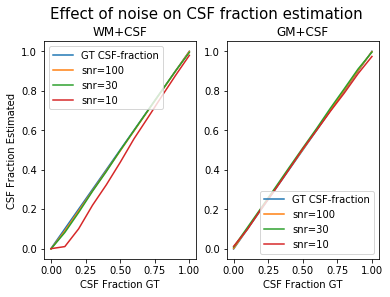

In [7]:
from dmipy.core.modeling_framework import MultiCompartmentSphericalHarmonicsModel
fr_csf = np.linspace(0, 1, 11)
fr_wm_gm = fr_csf[::-1]
fractions_wm_csf = np.zeros((11, 3))
fractions_wm_csf[:, 0] = fr_wm_gm
fractions_wm_csf[:, 2] = fr_csf

fractions_gm_csf = np.zeros((11, 3))
fractions_gm_csf[:, 1] = fr_wm_gm
fractions_gm_csf[:, 2] = fr_csf

data_wm_csf = []
data_gm_csf = []
for fractions in fractions_wm_csf:
    _, data = generate_synthetic_multi_tissue_data(scheme_hcp, tissue_response, fractions)
    data_wm_csf.append(data)
for fractions in fractions_gm_csf:
    _, data = generate_synthetic_multi_tissue_data(scheme_hcp, tissue_response, fractions)
    data_gm_csf.append(data)


fig, axs = plt.subplots(nrows=1, ncols=2)
for ax, data, title in zip(axs, [data_wm_csf, data_gm_csf], ['WM+CSF', 'GM+CSF']):
    ax.plot(fr_csf, fr_csf, label='GT CSF-fraction')
    for snr in [100, 30, 10]:
        data_stack = add_noise(np.tile(data, (50, 1)), snr=snr)

        responses_noisy = []
        for model in [wm, gm, csf]:
            data_synth = np.tile(model(scheme_hcp, mu=[0., 0.]), (1000, 1)) * model.S0_response
            data_noise = add_noise(data_synth, snr=snr)
            if model == wm:
                responses_noisy.append(AnisotropicTissueResponseModel(scheme_hcp, data_noise))
            else:
                responses_noisy.append(IsotropicTissueResponseModel(scheme_hcp, data_noise))

        mtcsd_mod_3shell = (
            MultiCompartmentSphericalHarmonicsModel(responses_noisy))
        mtcsf_fit = mtcsd_mod_3shell.fit(scheme_hcp, data_stack, fit_S0_response=True, verbose=False)
        mean_vf_csf = np.mean(mtcsf_fit.fitted_parameters['partial_volume_2'], axis=1)
        ax.plot(fr_csf, mean_vf_csf, label='snr={}'.format(snr))
        ax.set_title(title)
        ax.set_xlabel('CSF Fraction GT')
        ax.legend()
axs[0].set_ylabel('CSF Fraction Estimated')
fig.suptitle('Effect of noise on CSF fraction estimation', fontsize=15, y=1.);

Very strange alternative bad/good results

### Effect of free water elimination on q-space index estimation

In [10]:
snr=30

data_stack = add_noise(np.tile(data, (50, 1)), snr=snr)
responses_noisy = []
for model in [wm, gm, csf]:
    data_synth = np.tile(model(scheme_hcp, mu=[0., 0.]), (1000, 1)) * model.S0_response
    data_noise = add_noise(data_synth, snr=snr)
    if model == wm:
        responses_noisy.append(AnisotropicTissueResponseModel(scheme_hcp, data_noise))
    else:
        responses_noisy.append(IsotropicTissueResponseModel(scheme_hcp, data_noise))

mtcsd_mod_3shell = (
    MultiCompartmentSphericalHarmonicsModel(responses_noisy))

data_stack_wm_csf = add_noise(np.tile(data_wm_csf, (50, 1)), snr=snr)
data_stack_gm_csf = add_noise(np.tile(data_gm_csf, (50, 1)), snr=snr)

mtcsf_fit_wm = mtcsd_mod_3shell.fit(scheme_hcp, data_stack_wm_csf, fit_S0_response=True, verbose=False)
mtcsf_fit_gm = mtcsd_mod_3shell.fit(scheme_hcp, data_stack_gm_csf, fit_S0_response=True, verbose=False)

data_wm_csf_filtered = mtcsf_fit_wm.return_filtered_signal(['partial_volume_2'])
data_gm_csf_filtered = mtcsf_fit_gm.return_filtered_signal(['partial_volume_2'])

from dmipy.core.acquisition_scheme import gtab_dmipy2dipy
from dipy.reconst.mapmri import MapmriModel
gtab = gtab_dmipy2dipy(scheme_hcp)
mapmod = MapmriModel(gtab)

mapfit_wm_raw = mapmod.fit(data_stack_wm_csf)
mapfit_wm_filtered = mapmod.fit(data_wm_csf_filtered)
mapfit_gm_raw = mapmod.fit(data_stack_gm_csf)
mapfit_gm_filtered = mapmod.fit(data_gm_csf_filtered)

In [ ]:
plt.axhline

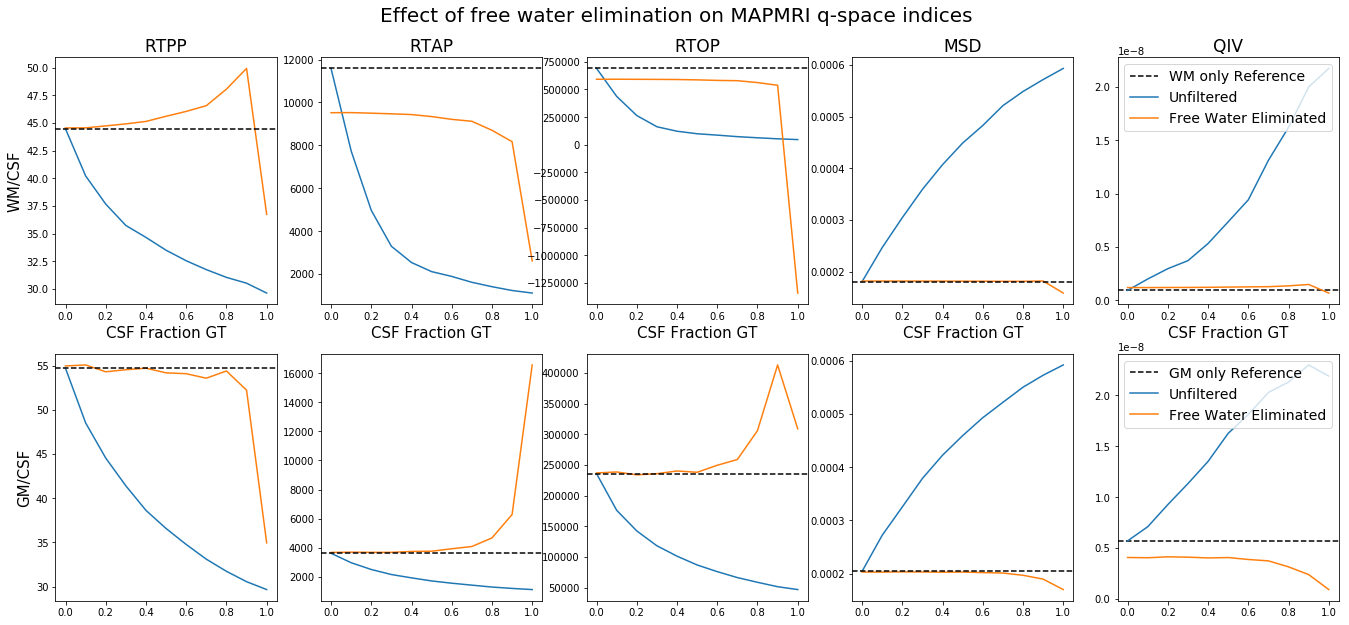

In [37]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=[23, 10])
axs = axs.ravel()

axs[0].set_title('RTPP', fontsize=17)
axs[1].set_title('RTAP', fontsize=17)
axs[2].set_title('RTOP', fontsize=17)
axs[3].set_title('MSD', fontsize=17)
axs[4].set_title('QIV', fontsize=17)
axs[0].set_xlabel('CSF Fraction GT', fontsize=15)
axs[1].set_xlabel('CSF Fraction GT', fontsize=15)
axs[2].set_xlabel('CSF Fraction GT', fontsize=15)
axs[3].set_xlabel('CSF Fraction GT', fontsize=15)
axs[4].set_xlabel('CSF Fraction GT', fontsize=15)
axs[0].set_ylabel('WM/CSF', fontsize=15)
axs[5].set_ylabel('GM/CSF', fontsize=15)

#wm
axs[0].plot(fr_csf, np.mean(mapfit_wm_raw.rtpp(), axis=1))
axs[0].plot(fr_csf, np.mean(mapfit_wm_filtered.rtpp(), axis=1))
axs[0].axhline(np.mean(mapfit_wm_raw.rtpp()[0]), c='k', ls='--')
axs[1].plot(fr_csf, np.mean(mapfit_wm_raw.rtap(), axis=1))
axs[1].plot(fr_csf, np.mean(mapfit_wm_filtered.rtap(), axis=1))
axs[1].axhline(np.mean(mapfit_wm_raw.rtap()[0]), c='k', ls='--')
axs[2].plot(fr_csf, np.mean(mapfit_wm_raw.rtop(), axis=1))
axs[2].plot(fr_csf, np.mean(mapfit_wm_filtered.rtop(), axis=1))
axs[2].axhline(np.mean(mapfit_wm_raw.rtop()[0]), c='k', ls='--')
axs[3].plot(fr_csf, np.mean(mapfit_wm_raw.msd(), axis=1))
axs[3].plot(fr_csf, np.mean(mapfit_wm_filtered.msd(), axis=1))
axs[3].axhline(np.mean(mapfit_wm_raw.msd()[0]), c='k', ls='--')
axs[4].axhline(np.mean(mapfit_wm_raw.qiv()[0]), c='k', ls='--', label='WM only Reference')
axs[4].plot(fr_csf, np.mean(mapfit_wm_raw.qiv(), axis=1), label='Unfiltered')
axs[4].plot(fr_csf, np.mean(mapfit_wm_filtered.qiv(), axis=1), label='Free Water Eliminated')

axs[4].legend(fontsize=14, loc='upper right')

#gm
axs[5].plot(fr_csf, np.mean(mapfit_gm_raw.rtpp(), axis=1))
axs[5].plot(fr_csf, np.mean(mapfit_gm_filtered.rtpp(), axis=1))
axs[5].axhline(np.mean(mapfit_gm_raw.rtpp()[0]), c='k', ls='--')
axs[6].plot(fr_csf, np.mean(mapfit_gm_raw.rtap(), axis=1))
axs[6].plot(fr_csf, np.mean(mapfit_gm_filtered.rtap(), axis=1))
axs[6].axhline(np.mean(mapfit_gm_raw.rtap()[0]), c='k', ls='--')
axs[7].plot(fr_csf, np.mean(mapfit_gm_raw.rtop(), axis=1))
axs[7].plot(fr_csf, np.mean(mapfit_gm_filtered.rtop(), axis=1))
axs[7].axhline(np.mean(mapfit_gm_raw.rtop()[0]), c='k', ls='--')
axs[8].plot(fr_csf, np.mean(mapfit_gm_raw.msd(), axis=1))
axs[8].plot(fr_csf, np.mean(mapfit_gm_filtered.msd(), axis=1))
axs[8].axhline(np.mean(mapfit_gm_raw.msd()[0]), c='k', ls='--')
axs[9].axhline(np.mean(mapfit_gm_raw.qiv()[0]), c='k', ls='--', label='GM only Reference')
axs[9].plot(fr_csf, np.mean(mapfit_gm_raw.qiv(), axis=1), label='Unfiltered')
axs[9].plot(fr_csf, np.mean(mapfit_gm_filtered.qiv(), axis=1), label='Free Water Eliminated')

axs[9].legend(fontsize=14, loc='upper right')

fig.suptitle('Effect of free water elimination on MAPMRI q-space indices', fontsize=20, y=0.95);

Things to notice:
- The filtering very nicely keeps the q-space index stable up to a CSF volume fraction of about 0.7. 
- RTAP and RTOP seem to be underestimated compared to the unfiltered signal for the WM/CSF experiment. One explanation This is likely because the FOD at sh_order=8 cannot represent the spike function (so just one macro-environment in one direction).

## HCP study on effect of free water elimination on MAP-MRI Indices

### Influence on overall q-space index maps

In [39]:
mtcsd_fit_3shell = mtcsd_mod_3shell.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, fit_S0_response=True, verbose=False)
data_hcp_csf_filtered = mtcsd_fit_3shell.return_filtered_signal(['partial_volume_2'])

mapfit_raw = mapmod.fit(data_hcp, mask=data_hcp[..., 0]>0)
mapfit_filtered = mapmod.fit(data_hcp_csf_filtered, mask=data_hcp_csf_filtered[..., 0]>0)

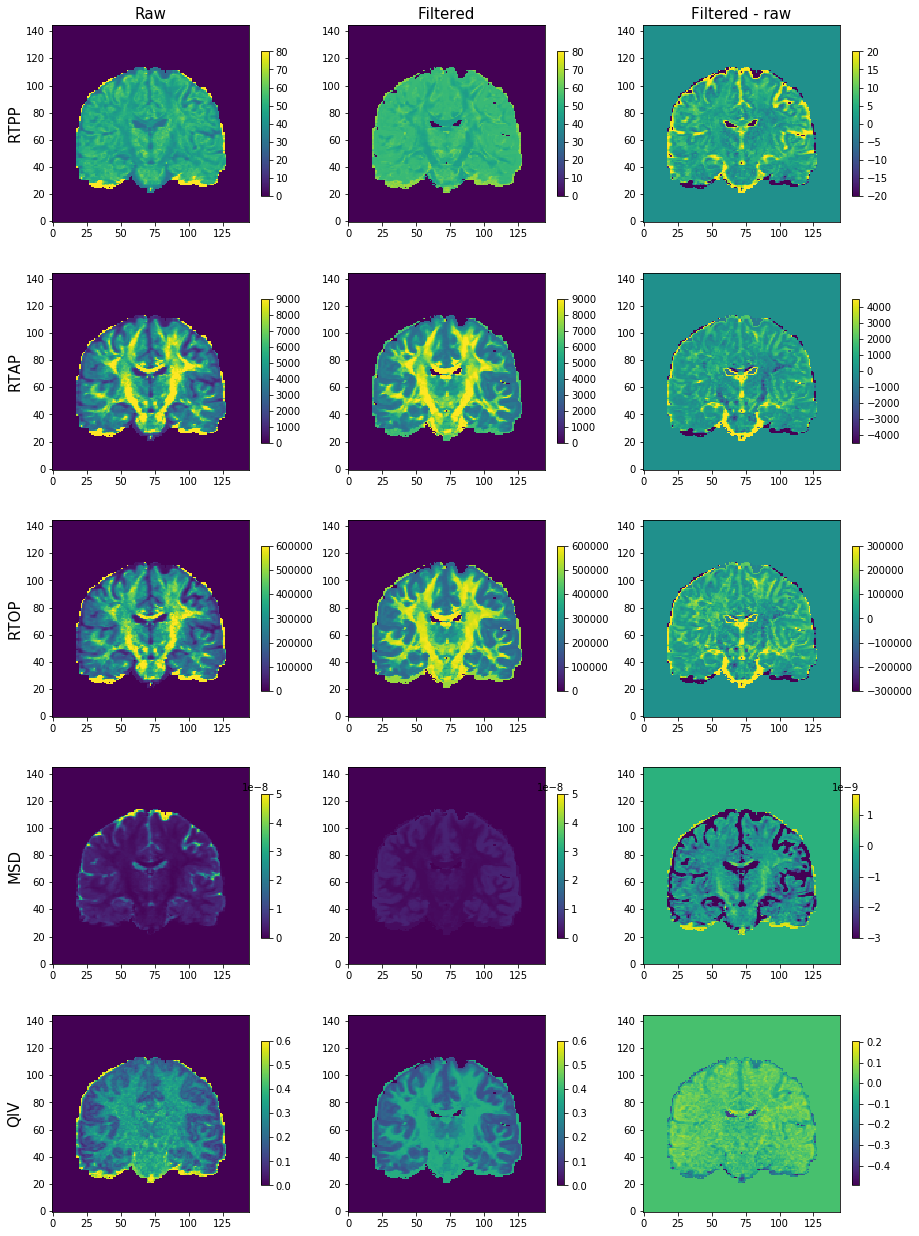

In [45]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=[15, 22])
axs = axs.ravel()

im = axs[0].imshow(mapfit_raw.rtpp().squeeze().T, origin=True, vmin=0, vmax=80)
fig.colorbar(im, ax=axs[0], shrink=0.7)
im = axs[1].imshow(mapfit_filtered.rtpp().squeeze().T, origin=True, vmin=0, vmax=80)
fig.colorbar(im, ax=axs[1], shrink=0.7)
im = axs[2].imshow((mapfit_filtered.rtpp().squeeze() - mapfit_raw.rtpp().squeeze()).T, origin=True, vmin=-20, vmax=20)
fig.colorbar(im, ax=axs[2], shrink=0.7)
im = axs[3].imshow(mapfit_raw.rtap().squeeze().T, origin=True, vmin=0, vmax=9e3)
fig.colorbar(im, ax=axs[3], shrink=0.7)
im = axs[4].imshow(mapfit_filtered.rtap().squeeze().T, origin=True, vmin=0, vmax=9e3)
fig.colorbar(im, ax=axs[4], shrink=0.7)
im = axs[5].imshow((mapfit_filtered.rtap().squeeze() - mapfit_raw.rtap().squeeze()).T, origin=True, vmin=-4.5e3, vmax=4.5e3)
fig.colorbar(im, ax=axs[5], shrink=0.7)
im = axs[6].imshow(mapfit_raw.rtop().squeeze().T, origin=True, vmin=0, vmax=6e5)
fig.colorbar(im, ax=axs[6], shrink=0.7)
im = axs[7].imshow(mapfit_filtered.rtop().squeeze().T, origin=True, vmin=0, vmax=6e5)
fig.colorbar(im, ax=axs[7], shrink=0.7)
im = axs[8].imshow((mapfit_filtered.rtop().squeeze() - mapfit_raw.rtop().squeeze()).T, origin=True, vmin=-3e5, vmax=3e5)
fig.colorbar(im, ax=axs[8], shrink=0.7)
im = axs[9].imshow(mapfit_raw.qiv().squeeze().T, origin=True, vmin=0, vmax=5e-8)
fig.colorbar(im, ax=axs[9], shrink=0.7)
im = axs[10].imshow(mapfit_filtered.qiv().squeeze().T, origin=True, vmin=0, vmax=5e-8)
fig.colorbar(im, ax=axs[10], shrink=0.7)
im = axs[11].imshow((mapfit_filtered.qiv().squeeze() - mapfit_raw.qiv().squeeze()).T, origin=True, vmin=-3e-9)
fig.colorbar(im, ax=axs[11], shrink=0.7)
im = axs[12].imshow(mapfit_raw.ng().squeeze().T, origin=True, vmin=0, vmax=0.6)
fig.colorbar(im, ax=axs[12], shrink=0.7)
im = axs[13].imshow(mapfit_filtered.ng().squeeze().T, origin=True, vmin=0, vmax=0.6)
fig.colorbar(im, ax=axs[13], shrink=0.7)
im = axs[14].imshow((mapfit_filtered.ng().squeeze() - mapfit_raw.ng().squeeze()).T, origin=True)
fig.colorbar(im, ax=axs[14], shrink=0.7)
axs[0].set_title('Raw', fontsize=15)
axs[1].set_title('Filtered', fontsize=15)
axs[2].set_title('Filtered - raw', fontsize=15)
axs[0].set_ylabel('RTPP', fontsize=15)
axs[3].set_ylabel('RTAP', fontsize=15)
axs[6].set_ylabel('RTOP', fontsize=15)
axs[9].set_ylabel('MSD', fontsize=15)
axs[12].set_ylabel('QIV', fontsize=15);

Things to notice:
- RTPP increases in WM/GM areas, decreases in CSF
- RTAP increases in WM and seems to decrease in some GM areas.
- RTOP increases in WM and some decreases in CSF
- MSD increases in WM and decreases in CSF
- QIV decreases in CSF and overall increases in WM

### Influence on DTI and q-space index histograms around Corpus Callosum

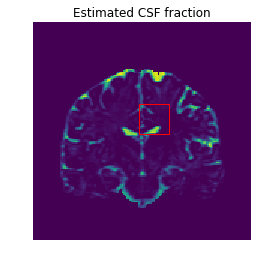

In [49]:
import matplotlib.patches as patches
fig, ax = plt.subplots(1)
ax.imshow(mtcsd_fit_3shell.fitted_parameters['partial_volume_2'].squeeze().T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('Estimated CSF fraction');

#### Effect on DTI indices

#### Effect on q-space indices

### References:
- Özarslan, Evren, et al. "Mean apparent propagator (MAP) MRI: a novel diffusion imaging method for mapping tissue microstructure." NeuroImage 78 (2013): 16-32.
- Fick, Rutger HJ, et al. "MAPL: Tissue microstructure estimation using Laplacian-regularized MAP-MRI and its application to HCP data." NeuroImage 134 (2016): 365-385.
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.